In [18]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d

from sklearn.externals import joblib
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

%matplotlib notebook


In [3]:

# CURATE DATA

data_path = 'data/20k_data.csv'
label_path = 'data/20k_labels.csv'

data = pd.read_csv(data_path, low_memory=False)
label = pd.read_csv(label_path, low_memory=False)

headers = ['x', 'y', 'z']
num_objs = (data.shape[1] - 3) // 2

dists = []
heights = []
for i in range(num_objs):
    dists.append('dist_' + str(i))
    heights.append('height_' + str(i))
    headers.append('dist_' + str(i))
    headers.append('height_' + str(i))
    
data.columns = headers
data = data.replace(to_replace='None', value=0).astype('float')


In [55]:

# CURATE ONLY MAX HEIGHT DATA

h_col = data[heights].idxmax(axis=1)
h_ind = [data.columns.get_loc(c) for c in h_col]

data_mh_list = [data.iloc[i, [0, 1, 2, h_ind[i]-1, h_ind[i]]].tolist() for i in range(len(h_ind))]
mh_headers = ['x', 'y', 'z', 'dist', 'height']
mh = pd.DataFrame(data_mh_list, columns=mh_headers)
mhl = label.join(mh)

hitable_groups = mhl.groupby(lambda x: 'Hitable' if mhl.iloc[x]['f'] != 0 else 'Unhitable')
mhl_hit = hitable_groups.get_group('Hitable')
mhl_unhit = hitable_groups.get_group('Unhitable')

mhf = mhl.groupby('f').get_group(1.0) # Max Force only allows hitable
hitable = mhl['f'].mask(mhl['f'] > 0, 1)

mh_squared = mh.copy().pow(2).rename(lambda x: x+'^2', axis='columns')
mh_non_zero = mh.copy()
num = mh_non_zero._get_numeric_data()
num[num < 0] = 0
mh_root = mh_non_zero.pow(.5).rename(lambda x: x+'_root', axis='columns')
nl_mh_just_squared = pd.concat([mh, mh_squared], axis=1)
nl_mh = pd.concat([mh, mh_squared, mh_root], axis=1)


<IPython.core.display.Javascript object>


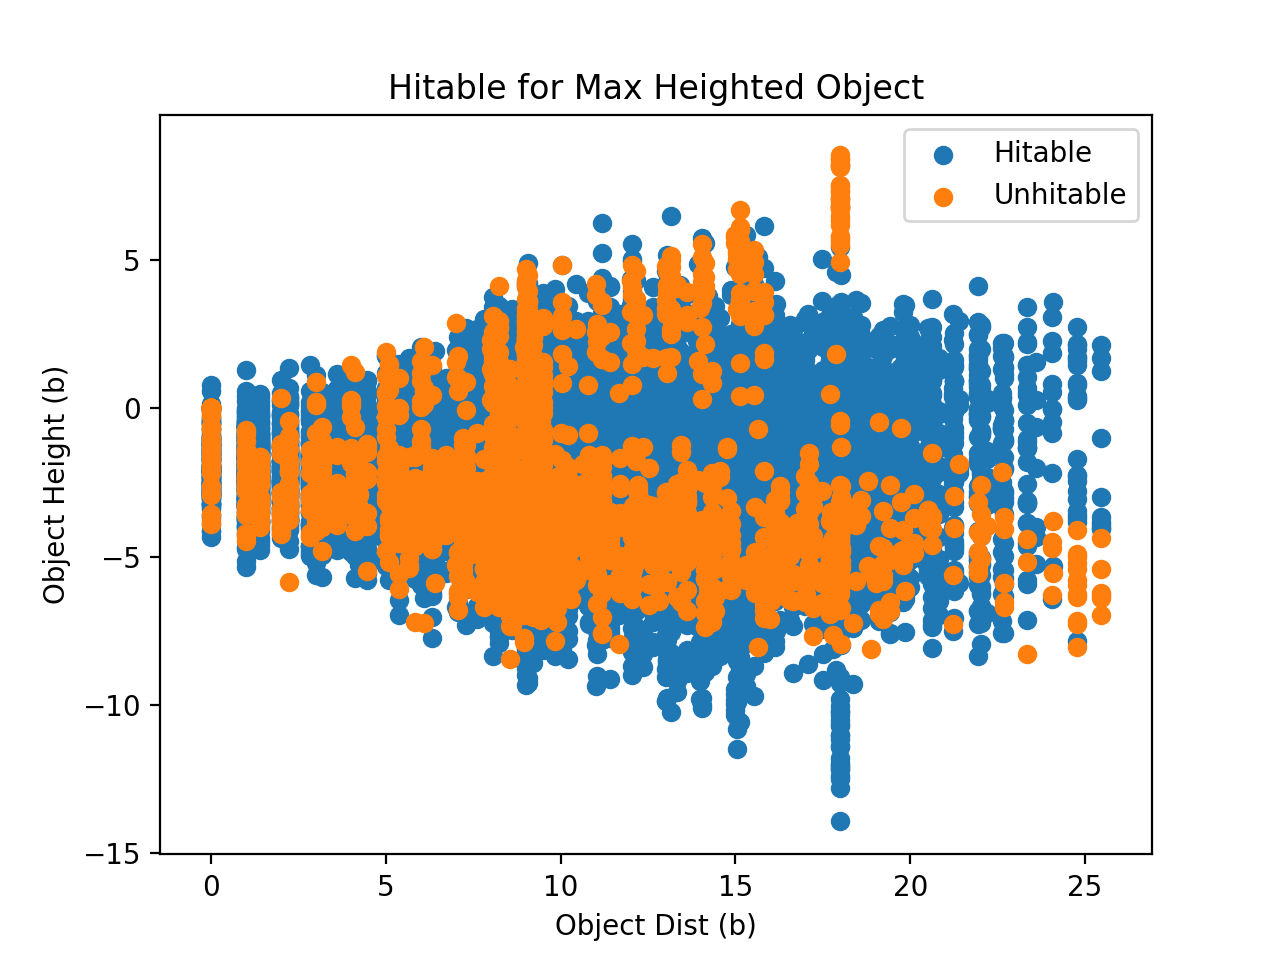

In [242]:

# CAN DETERMINE HITABLE FROM MAX HEIGHTED OBJECT

plt.figure(0)
for name, group in hitable_groups:
    plt.scatter(group['dist'], group['height'], label=name)    
plt.title('Hitable for Max Heighted Object')
plt.xlabel('Object Dist (b)')
plt.ylabel('Object Height (b)')
plt.legend()
plt.show()

# There seems to be some correlation between targets that are hitable and unhitable provided
# just he maximum heighted object. It does not look linarly seprable...


<IPython.core.display.Javascript object>


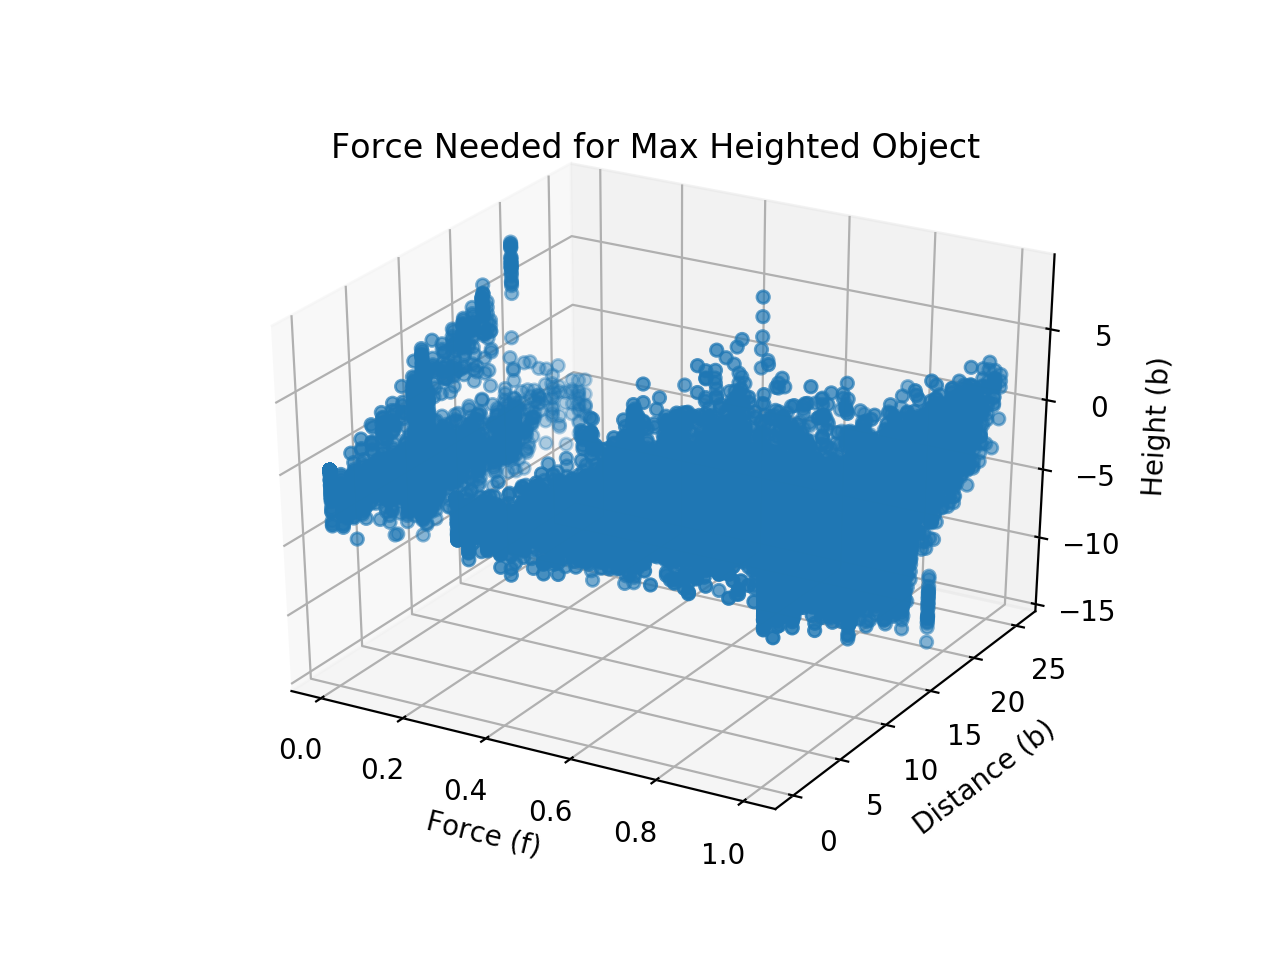

In [243]:

# FORCE PLOT MAX HEIGHTED OBJECT

figure = plt.figure(1).gca(projection='3d')
figure.scatter(mhl['f'], mhl['dist'], mhl['height'])
figure.set_title('Force Needed for Max Heighted Object')
figure.set_xlabel('Force (f)')
figure.set_ylabel('Distance (b)')
figure.set_zlabel('Height (b)')
plt.show()


<IPython.core.display.Javascript object>


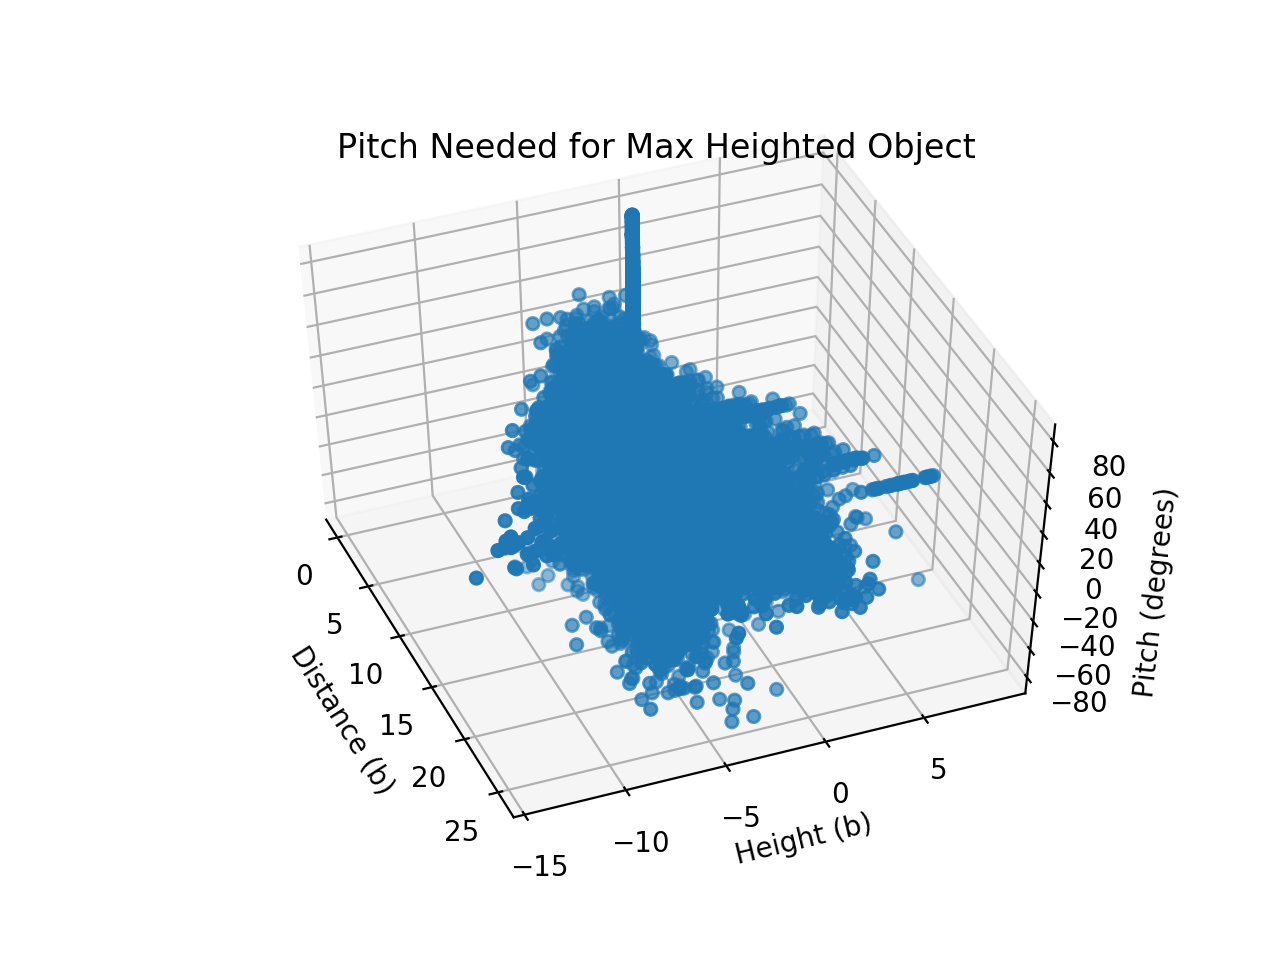

<IPython.core.display.Javascript object>


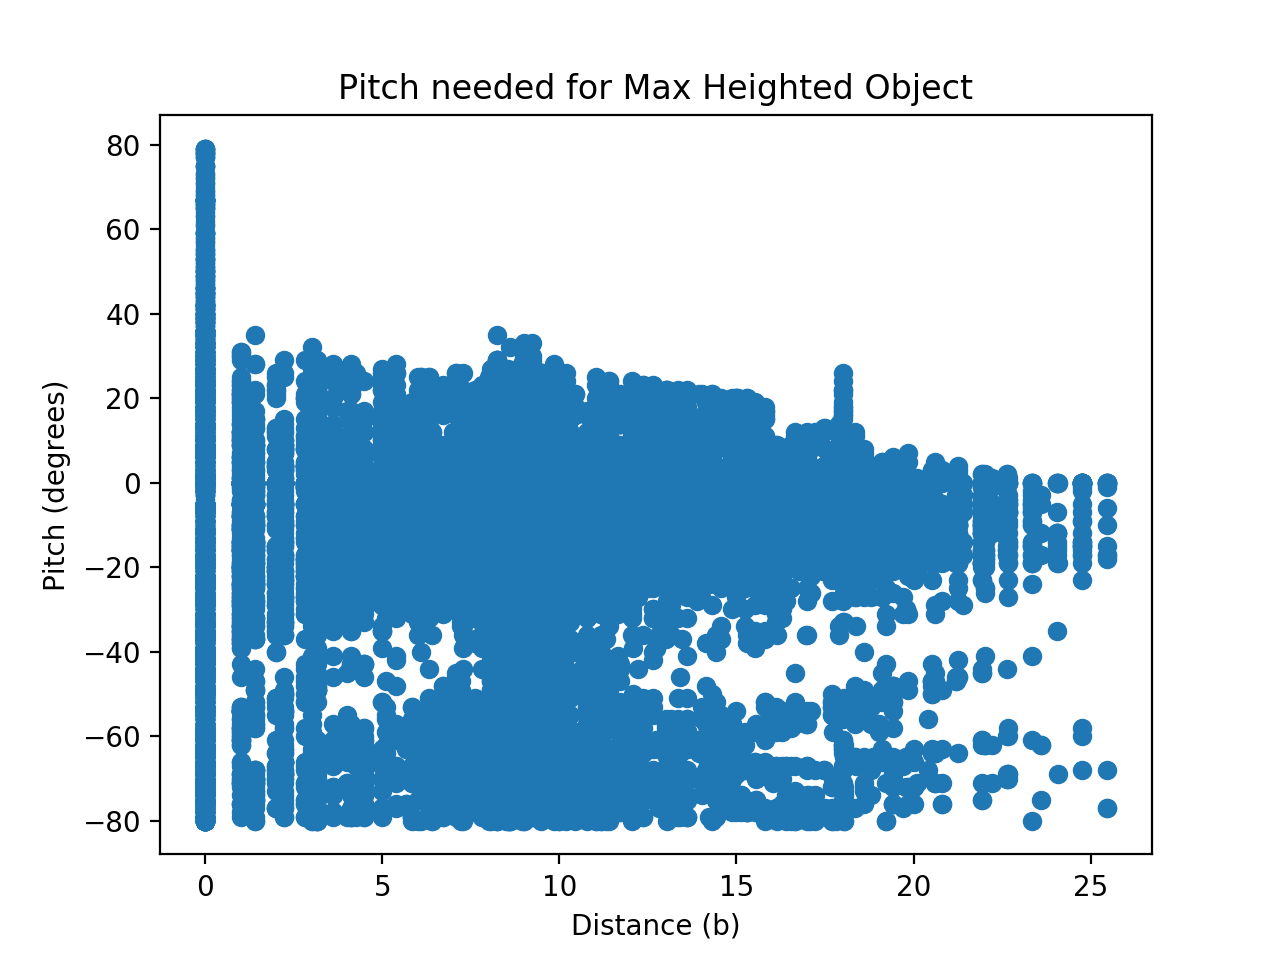

In [244]:

# PITCH PLOT MAX HEIGHTED OBJECT

figure = plt.figure(2).gca(projection='3d')
figure.scatter(mhl['dist'], mhl['height'], mhl['pitch'])
figure.set_title('Pitch Needed for Max Heighted Object')
figure.set_xlabel('Distance (b)')
figure.set_ylabel('Height (b)')
figure.set_zlabel('Pitch (degrees)')

figure = plt.figure(3)
plt.scatter(mhl['dist'], mhl['pitch'])
plt.title('Pitch needed for Max Heighted Object')
plt.xlabel('Distance (b)')
plt.ylabel('Pitch (degrees)')
plt.show()


<IPython.core.display.Javascript object>


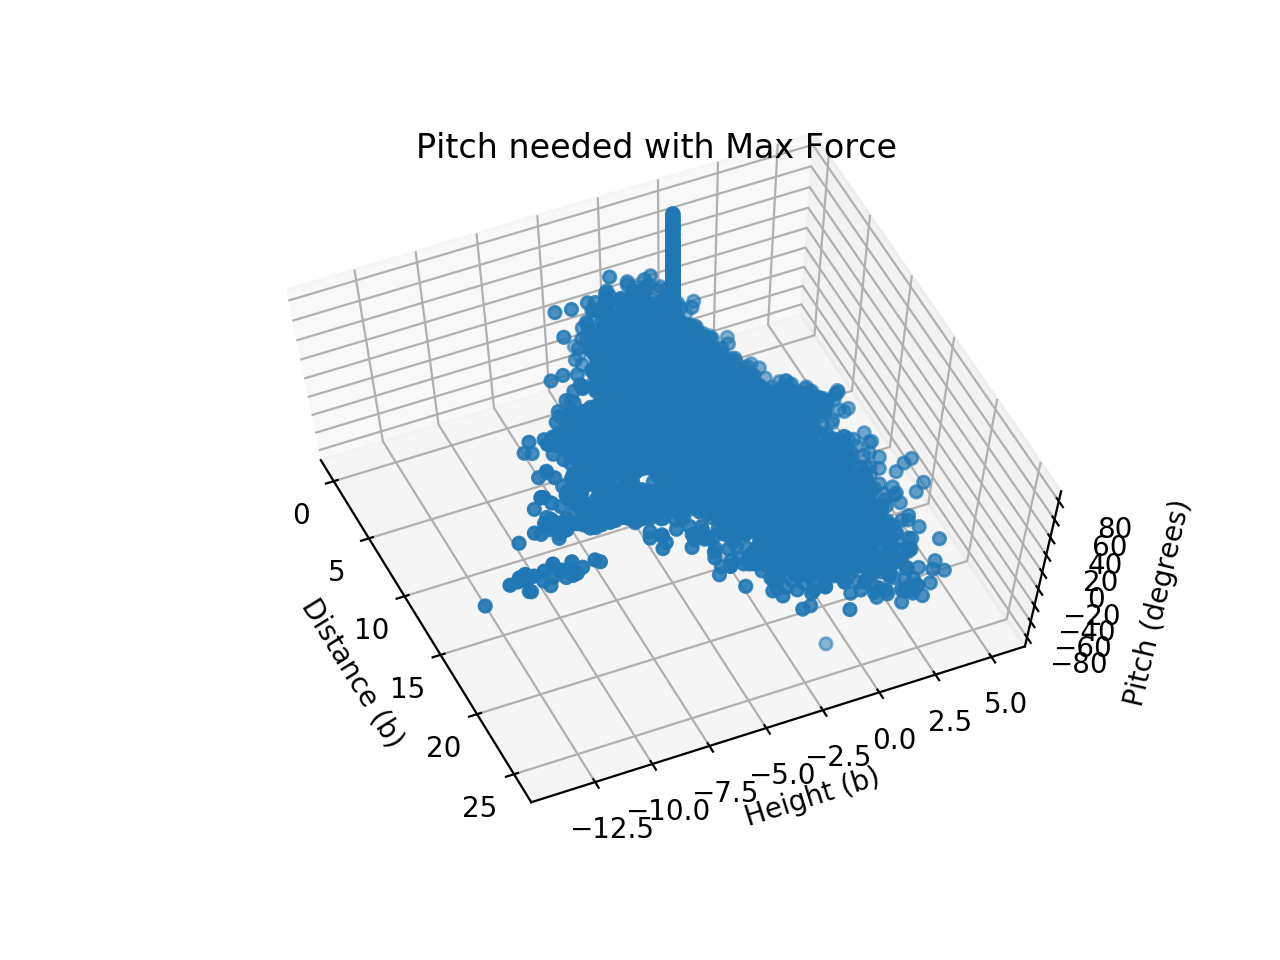

Text(0.5,0,'Pitch (degrees)')

In [245]:

# DETERMINE PITCH FROM MAX FORCE MAX HEIGHTED OBJECT

figure = plt.figure(4).gca(projection='3d')
figure.scatter(mf['dist'], mhf['height'], mhf['pitch'])
figure.set_title('Pitch needed with Max Force')
figure.set_xlabel('Distance (b)')
figure.set_ylabel('Height (b)')
figure.set_zlabel('Pitch (degrees)')


In [20]:

# RIDGE REGRESSION FOR PITCH ON MAX FORCE MAX HEIGHTED OBJECT

X = mhf[['x', 'y', 'z', 'dist', 'height']]
y = mhf['pitch']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'models/Ridge_Pitch_MF_MHO_HIT.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# Understandable scoring, this isn't terrible for Ridge. Could definately be 
# improved.
#
# BEST: 0.7887022927621963 ALPHA: 10.0


BEST: 0.7887022927621963 ALPHA: 10.0
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}          0.789568         0.788702                7
1     {'alpha': 0.0001}          0.789568         0.788702                6
2      {'alpha': 0.001}          0.789568         0.788702                5
3       {'alpha': 0.01}          0.789568         0.788702                4
4        {'alpha': 0.1}          0.789568         0.788702                3
5        {'alpha': 1.0}          0.789568         0.788702                2
6       {'alpha': 10.0}          0.789568         0.788702                1
7      {'alpha': 100.0}          0.789557         0.788699                8
8     {'alpha': 1000.0}          0.788812         0.788016                9
9    {'alpha': 10000.0}          0.769350         0.768831               10
10  {'alpha': 100000.0}          0.559389         0.559049               11


In [22]:

# RIDGE REGRESSION FOR PITCH ON MAX HEIGHTED OBJECT HITABLE ONLY

X = mhl_hit[['x', 'y', 'z', 'dist', 'height']]
y = mhl_hit['pitch']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'models/Ridge_Pitch_MHO_HIT.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# Okay, with the horrendous train score this new dataset with a varying
# force it seems that adding force causes the target function to no longer
# be linear in nature.
#
# BEST: 0.08124235068738328 ALPHA: 10.0


BEST: 0.08124235068738328 ALPHA: 10.0
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}          0.082199         0.081242                7
1     {'alpha': 0.0001}          0.082199         0.081242                6
2      {'alpha': 0.001}          0.082199         0.081242                5
3       {'alpha': 0.01}          0.082199         0.081242                4
4        {'alpha': 0.1}          0.082199         0.081242                3
5        {'alpha': 1.0}          0.082199         0.081242                2
6       {'alpha': 10.0}          0.082199         0.081242                1
7      {'alpha': 100.0}          0.082187         0.081232                8
8     {'alpha': 1000.0}          0.081206         0.080265                9
9    {'alpha': 10000.0}          0.057631         0.056691               10
10  {'alpha': 100000.0}          0.013901         0.013036               11


In [24]:

# RIDGE REGRESSION FOR PITCH ON MAX HEIGHTED OBJECT

X = mhl[['x', 'y', 'z', 'dist', 'height']]
y = mhl['pitch']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'models/Ridge_Pitch_MHO.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# It seems that attempting to predict the pitch with varying force AND incluing
# targets that cannot be hit reduces the ability to hit the target by over 50%.
# For the remainder of this section only hitable targets will be used.
#
# BEST: 0.02036305938423631 ALPHA: 100.0


BEST: 0.02036305938423631 ALPHA: 100.0
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}          0.024417         0.020353                8
1     {'alpha': 0.0001}          0.024417         0.020353                7
2      {'alpha': 0.001}          0.024417         0.020353                6
3       {'alpha': 0.01}          0.024417         0.020353                5
4        {'alpha': 0.1}          0.024417         0.020353                4
5        {'alpha': 1.0}          0.024417         0.020353                3
6       {'alpha': 10.0}          0.024417         0.020354                2
7      {'alpha': 100.0}          0.024415         0.020363                1
8     {'alpha': 1000.0}          0.024310         0.020349                9
9    {'alpha': 10000.0}          0.020537         0.017025               10
10  {'alpha': 100000.0}          0.008668         0.005749               11


In [26]:

# RIDGE REGRESSION FOR PITCH/YAW/FORCE WITH MAX FORCE ON MAX HEIGHTED OBJECT

X = mhf[['x', 'y', 'z', 'dist', 'height']]
y = mhf[['pitch', 'yaw', 'f']]
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'models/Ridge_Pitch_Yaw_Force_MF_MHO.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# Okay, there was a huge drop from calculating just the Pitch. Time to investigate
# and see which of the added two target parameters ruined the scoring. Probably the
# yaw as it's non-linear and ridge is a linear method.
#
# BEST: 0.5704921089542141 ALPHA: 100.0


BEST: 0.5704921089542141 ALPHA: 100.0
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}          0.571177         0.570491                8
1     {'alpha': 0.0001}          0.571177         0.570491                7
2      {'alpha': 0.001}          0.571177         0.570491                6
3       {'alpha': 0.01}          0.571177         0.570491                5
4        {'alpha': 0.1}          0.571177         0.570491                4
5        {'alpha': 1.0}          0.571177         0.570491                3
6       {'alpha': 10.0}          0.571177         0.570491                2
7      {'alpha': 100.0}          0.571177         0.570492                1
8     {'alpha': 1000.0}          0.571139         0.570469                9
9    {'alpha': 10000.0}          0.570337         0.569731               10
10  {'alpha': 100000.0}          0.559550         0.559128               11


In [28]:

# RIDGE REGRESSION FOR YAW WITH MAX FORCE ON MAX HEIGHTED OBJECT

X = mhf[['x', 'y', 'z', 'dist', 'height']]
y = mhf['yaw']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'models/Ridge_Yaw_MF_MHO.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# Target Function:
#     -180 * math.atan2(dx, dz) / math.pi
#
# This is understandable as the target function is not linear...
#
# BEST: 0.5640759291789648 ALPHA: 100.0


BEST: 0.5640759291789648 ALPHA: 100.0
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}          0.564762         0.564074                8
1     {'alpha': 0.0001}          0.564762         0.564074                7
2      {'alpha': 0.001}          0.564762         0.564074                6
3       {'alpha': 0.01}          0.564762         0.564074                5
4        {'alpha': 0.1}          0.564762         0.564074                4
5        {'alpha': 1.0}          0.564762         0.564074                3
6       {'alpha': 10.0}          0.564762         0.564075                2
7      {'alpha': 100.0}          0.564762         0.564076                1
8     {'alpha': 1000.0}          0.564746         0.564073                9
9    {'alpha': 10000.0}          0.564491         0.563881               10
10  {'alpha': 100000.0}          0.559555         0.559134               11


In [30]:

# RIDGE REGRESSION FOR YAW WITH MAX FORCE AND JUST COORDS

X = mhf[['x', 'y', 'z']]
y = mhf['yaw']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'models/Ridge_Yaw_MF_COORDS.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# Target Function:
#     -180 * math.atan2(dx, dz) / math.pi
#
# Again, this is understandable as the target function is not linear.
# It also shows that the height and distance of the largest obstacle do
# not impact the yaw equation... which they clearly don't.
#
# BEST: 0.5636829559473956 ALPHA: 1000.0


BEST: 0.5636829559473956 ALPHA: 1000.0
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}          0.564207         0.563681                9
1     {'alpha': 0.0001}          0.564207         0.563681                8
2      {'alpha': 0.001}          0.564207         0.563681                7
3       {'alpha': 0.01}          0.564207         0.563681                6
4        {'alpha': 0.1}          0.564207         0.563681                5
5        {'alpha': 1.0}          0.564207         0.563681                4
6       {'alpha': 10.0}          0.564207         0.563681                3
7      {'alpha': 100.0}          0.564207         0.563681                2
8     {'alpha': 1000.0}          0.564206         0.563683                1
9    {'alpha': 10000.0}          0.564150         0.563649               10
10  {'alpha': 100000.0}          0.559425         0.559084               11


In [31]:

# RIDGE REGRESSION FOR YAW WITH MAX FORCE AND JUST XZ

X = mhf[['x', 'z']]
y = mhf['yaw']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'models/Ridge_Yaw_XZ.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# Target Function:
#     -180 * math.atan2(dx, dz) / math.pi
#
# This shows that the 'y' feature provides no information for the solution.
#
# BEST: 0.5637371520275183 ALPHA: 1000.0


BEST: 0.5637371520275183 ALPHA: 1000.0
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}          0.564193         0.563736                9
1     {'alpha': 0.0001}          0.564193         0.563736                8
2      {'alpha': 0.001}          0.564193         0.563736                7
3       {'alpha': 0.01}          0.564193         0.563736                6
4        {'alpha': 0.1}          0.564193         0.563736                5
5        {'alpha': 1.0}          0.564193         0.563736                4
6       {'alpha': 10.0}          0.564193         0.563736                3
7      {'alpha': 100.0}          0.564193         0.563736                2
8     {'alpha': 1000.0}          0.564193         0.563737                1
9    {'alpha': 10000.0}          0.564137         0.563697               10
10  {'alpha': 100000.0}          0.559416         0.559102               11


In [32]:

# RIDGE REGRESSION FOR FORCE ON MAX HEIGHTED OBJECT HITABLE ONLY

X = mhl_hit[['x', 'y', 'z', 'dist', 'height']]
y = mhl_hit['f']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'models/Ridge_Force_MHO_HIT.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# This is understandable as predicting pitch on the max heighted object not constrained
# to full force caused a dramatic decrease in score. This highly indicates that the resulting
# function needed to model this behavior is non-linear.
#
# BEST: 0.43837377420120976 ALPHA: 1e-05


BEST: 0.43837377420120976 ALPHA: 1e-05
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}          0.438812         0.438374                1
1     {'alpha': 0.0001}          0.438812         0.438374                2
2      {'alpha': 0.001}          0.438812         0.438374                3
3       {'alpha': 0.01}          0.438812         0.438374                4
4        {'alpha': 0.1}          0.438812         0.438374                5
5        {'alpha': 1.0}          0.438812         0.438374                6
6       {'alpha': 10.0}          0.438811         0.438373                7
7      {'alpha': 100.0}          0.438798         0.438359                8
8     {'alpha': 1000.0}          0.437700         0.437248                9
9    {'alpha': 10000.0}          0.410331         0.409816               10
10  {'alpha': 100000.0}          0.322325         0.321853               11


In [16]:

# SVM TO DETERMINE IF HITABLE OR NOT MAXIMUM HEIGHTED OBJECT

X = mhl[['x', 'y', 'z', 'dist', 'height']]
X_train, X_test, y_train, y_test = train_test_split(X[:5000], 
                                                    hitable[:5000], 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': np.arange(0, 1, .1),
}
svc = SVC()
grid = GridSearchCV(estimator=svc, param_grid=params, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'models/SVM_Hitable_MHO.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'PARAMS:', grid.best_params_)
print(pd.DataFrame(grid.cv_results_)[columns])

# While above it was determined that a plot of height and distance for the tallest object did
# not provide a linearly seprable looking dataset it was worth trying an SVM to determine if a target
# is hitable or not.
#
# As shown, the SVM was able to classify, based on the maximum heighted object, if the target was hittable
# or not 90ish percent of the time. The remaining ten percent of the time might be due to another object in
# the way.
#
# The best kernel to use is a non-linear kind. That doesn't mean the data isn't linearly seprable as the
# linear kernel gets comparable results. 
#
# BEST: 0.8934328358208955 PARAMS: {'gamma': 0.1, 'kernel': 'rbf'}


BEST: 0.8934328358208955 PARAMS: {'gamma': 0.1, 'kernel': 'rbf'}
                                               params  mean_train_score  \
0                  {'gamma': 0.0, 'kernel': 'linear'}          0.882237   
1                     {'gamma': 0.0, 'kernel': 'rbf'}          0.877015   
2                 {'gamma': 0.0, 'kernel': 'sigmoid'}          0.877015   
3                  {'gamma': 0.1, 'kernel': 'linear'}          0.882237   
4                     {'gamma': 0.1, 'kernel': 'rbf'}          0.943281   
5                 {'gamma': 0.1, 'kernel': 'sigmoid'}          0.770596   
6                  {'gamma': 0.2, 'kernel': 'linear'}          0.882237   
7                     {'gamma': 0.2, 'kernel': 'rbf'}          0.961341   
8                 {'gamma': 0.2, 'kernel': 'sigmoid'}          0.768507   
9   {'gamma': 0.30000000000000004, 'kernel': 'line...          0.882237   
10    {'gamma': 0.30000000000000004, 'kernel': 'rbf'}          0.968804   
11  {'gamma': 0.30000000000000004, 

In [56]:

# RIDGE REGRESSION FOR PITCH ON MAX HEIGHTED OBJECT (NONLINEARITY ADDED)

X = nl_mh_just_squared
y = mhl['pitch']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'models/Ridge_Pitch_MHO_HIT.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# If you remember from before ridge regression produced the below results:
# BEST: 0.08124235068738328 ALPHA: 10.0
#
# It was theorized that what was created was a problem with a non-linear solution.
# After adding some non-linearity to the dataset. Mainly by adding the squares of each
# feature to the dataset. This resulted in a slight increase of accuracy from 8% to 12%.
# This increase shows there might be a non-linear fit to this data.
#
# Now these are new results:
# BEST: 0.1287202620999472 ALPHA: 1e-05


BEST: 0.1287202620999472 ALPHA: 1e-05
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}          0.132545         0.128720                1
1     {'alpha': 0.0001}          0.132545         0.128720                2
2      {'alpha': 0.001}          0.132545         0.128720                3
3       {'alpha': 0.01}          0.132545         0.128720                4
4        {'alpha': 0.1}          0.132545         0.128720                5
5        {'alpha': 1.0}          0.132545         0.128720                6
6       {'alpha': 10.0}          0.132544         0.128716                7
7      {'alpha': 100.0}          0.132474         0.128620                8
8     {'alpha': 1000.0}          0.129869         0.125833                9
9    {'alpha': 10000.0}          0.121143         0.116865               10
10  {'alpha': 100000.0}          0.116397         0.112486               11


In [57]:

# RIDGE REGRESSION FOR PITCH ON MAX HEIGHTED OBJECT (NON-LINEARITY ADDED)

X = nl_mh
y = mhl['pitch']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'models/Ridge_Pitch_MHO_HIT.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# If you remember from before ridge regression produced the below results:
# BEST: 0.08124235068738328 ALPHA: 10.0
#
# With the addition of the square roots and squares of all the features the 
# accuracy jumped up from 8% to 14% leading more creditability to the fact this
# data might have a non-linear solution.
# 
# BEST: 0.14394117065908307 ALPHA: 1e-05


BEST: 0.14394117065908307 ALPHA: 1e-05
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}          0.148158         0.143941                1
1     {'alpha': 0.0001}          0.148158         0.143941                2
2      {'alpha': 0.001}          0.148158         0.143941                3
3       {'alpha': 0.01}          0.148158         0.143941                4
4        {'alpha': 0.1}          0.148158         0.143941                5
5        {'alpha': 1.0}          0.148158         0.143940                6
6       {'alpha': 10.0}          0.148134         0.143912                7
7      {'alpha': 100.0}          0.147586         0.143369                8
8     {'alpha': 1000.0}          0.140663         0.136449                9
9    {'alpha': 10000.0}          0.124641         0.120342               10
10  {'alpha': 100000.0}          0.117359         0.113441               11


In [59]:

# RIDGE REGRESSION FOR YAW WITH ON MAX HEIGHTED OBJECT (NON-LINEARITY ADDED)

X = nl_mh
y = mhl['yaw']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'models/Ridge_Yaw_MF_MHO.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# Without Non-linearity added: # BEST: 0.5640759291789648 ALPHA: 100.0
#
# Target Function:
#     -180 * math.atan2(dx, dz) / math.pi
#
# It's understandable that adding the square roots and squares of the data will not
# have a large impact on this problem as it requires tan^2 in determining the final
# function which a simple addition of non-tan^2 features will probably not impact significantly.
#
# BEST: 0.5884577385635079 ALPHA: 10.0

BEST: 0.5884577385635079 ALPHA: 10.0
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}          0.589899         0.588434                7
1     {'alpha': 0.0001}          0.589899         0.588434                6
2      {'alpha': 0.001}          0.589899         0.588434                5
3       {'alpha': 0.01}          0.589899         0.588434                4
4        {'alpha': 0.1}          0.589899         0.588435                3
5        {'alpha': 1.0}          0.589899         0.588438                2
6       {'alpha': 10.0}          0.589894         0.588458                1
7      {'alpha': 100.0}          0.589610         0.588278                8
8     {'alpha': 1000.0}          0.577867         0.576826                9
9    {'alpha': 10000.0}          0.525518         0.524709               10
10  {'alpha': 100000.0}          0.503295         0.502626               11
